In [1]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install TA-Lib

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ta-lib


The following packages will be downloaded:

    package                    |            build
    ---------

In [3]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
%matplotlib inline

ticker= "2454.TW"
stock_data = yf.download(ticker, start="2018-01-04", end="2022-12-15")

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-04,301.0,307.0,298.0,307.0,247.233368,6783498
2018-01-05,310.0,310.0,297.0,300.0,241.596130,4965501
2018-01-08,304.0,306.0,296.0,298.0,239.985474,4142031
2018-01-09,297.0,304.0,296.0,304.0,244.817413,5147465
2018-01-10,304.5,311.0,302.0,309.5,249.246658,6727283


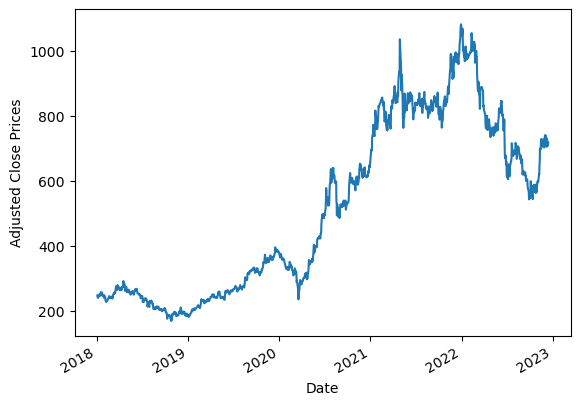

In [5]:
stock_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

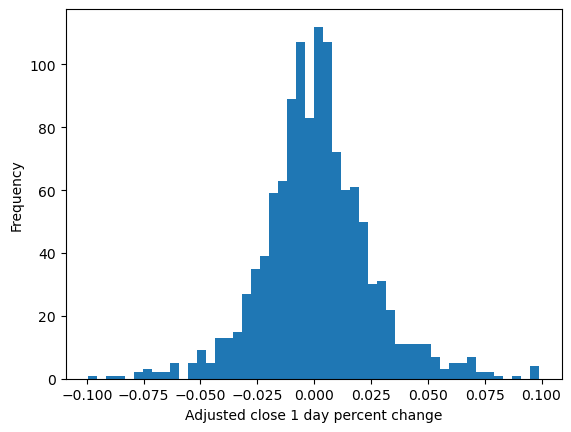

In [6]:
stock_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

In [7]:
feature_names = []
for n in [14, 30, 50, 200]:
    stock_data['ma'  + str(n)] = talib.SMA(stock_data['Adj Close'].values, timeperiod = n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Adj Close'].values, timeperiod = n)
    
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [8]:
stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change()

In [9]:
stock_data['5d_future_close'] = stock_data['Adj Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

In [10]:
feature_names

['ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']

In [11]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Volume_1d_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2018-01-04,301.0,307.0,298.0,307.0,247.233368,6783498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.428040,NaN
2018-01-05,310.0,310.0,297.0,300.0,241.596130,4965501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.268003,249.246658,NaN
2018-01-08,304.0,306.0,296.0,298.0,239.985474,4142031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.165838,252.065292,NaN
2018-01-09,297.0,304.0,296.0,304.0,244.817413,5147465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242739,251.259964,NaN
2018-01-10,304.5,311.0,302.0,309.5,249.246658,6727283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.306912,246.830704,NaN


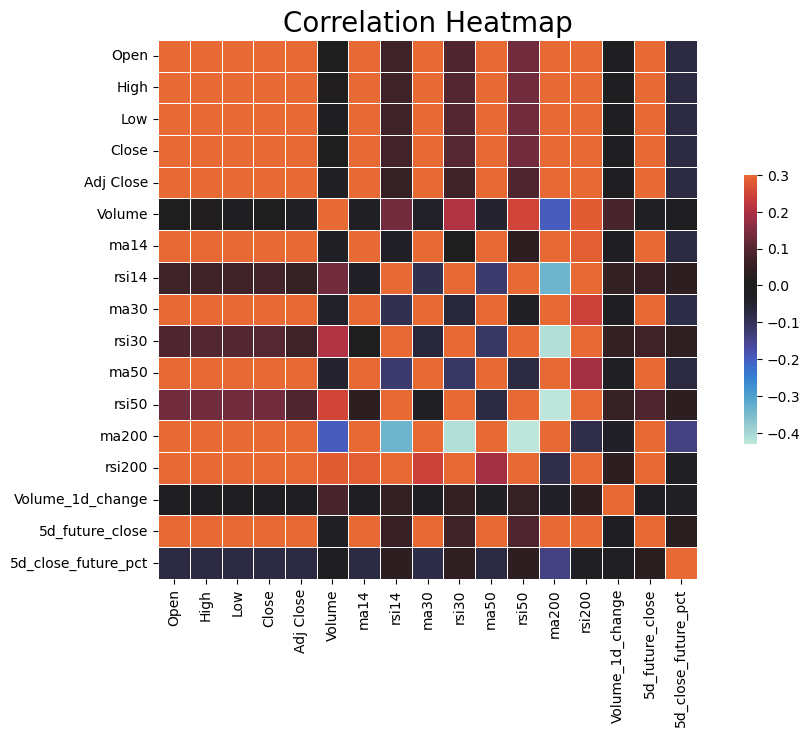

In [12]:
import seaborn as sns
# Computing the  Correlation Matrix using only the features that have 'mean' in their name.
cols = [col for col in stock_data.columns]
corr = stock_data[cols].corr()

#the matplotlib figure
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corr, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig("Corr_Heatmap.png")

In [13]:
stock_data.dropna(inplace = True)
X = stock_data[feature_names]
Y = stock_data['5d_close_future_pct']
train_size = int(0.90 * Y.shape[0])
X_train = X[:train_size]
y_train = Y[:train_size]
X_test = X[train_size:]
y_test = Y[train_size:]

In [14]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10, shuffle=True, random_state=42)

Training Mean accuracy: 0.2241553605287611
Standard deviation: 0.050905711619369465


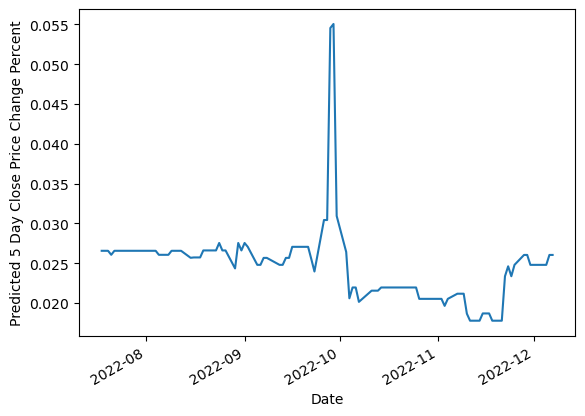

Mean Absolute Error: 0.045025617172199314
Mean Squared Error: 0.0030902106914830305
Root Mean Squared Error: 0.055589663530939186


In [15]:
rf_model = RandomForestRegressor(n_estimators = 50, max_depth = 4, max_features = 4, random_state = 1)
scores = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Training Mean accuracy:', scores.mean())
print('Standard deviation:', scores.std())
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Training Mean accuracy: 0.49971447417607007
Standard deviation: 0.07414865423415541


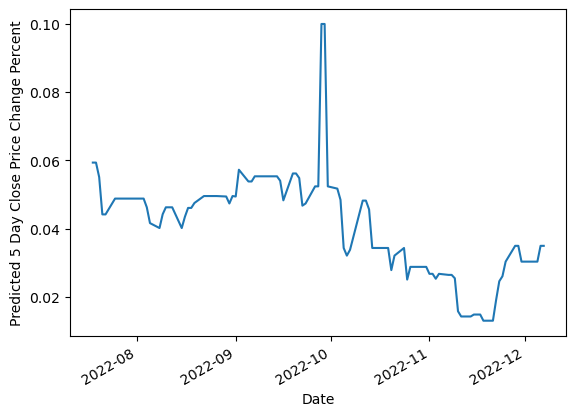

Mean Absolute Error: 0.05550531932173453
Mean Squared Error: 0.004520026028882358
Root Mean Squared Error: 0.06723113883374547


In [16]:
rf_model = RandomForestRegressor(n_estimators = 20, max_depth = 8, max_features = 4, random_state = 1)
scores = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Training Mean accuracy:', scores.mean())
print('Standard deviation:', scores.std())
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Training Mean accuracy: 0.21528582634986132
Standard deviation: 0.0493697011211821


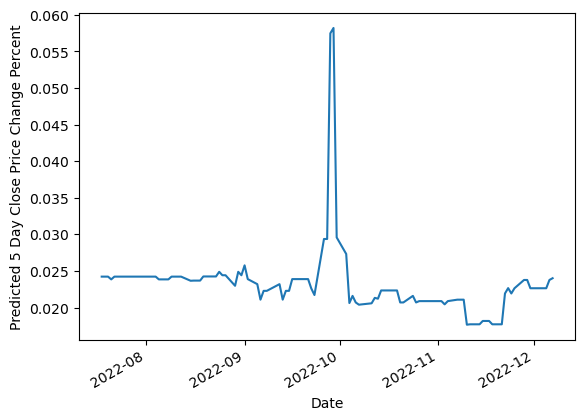

Mean Absolute Error: 0.0438011790616841
Mean Squared Error: 0.002960763041447668
Root Mean Squared Error: 0.05441289407344245


In [17]:
rf_model = RandomForestRegressor(n_estimators = 100, max_depth = 4, max_features = 4, random_state = 1)
scores = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Training Mean accuracy:', scores.mean())
print('Standard deviation:', scores.std())
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Training Mean accuracy: 0.21528582634986132
Standard deviation: 0.0493697011211821


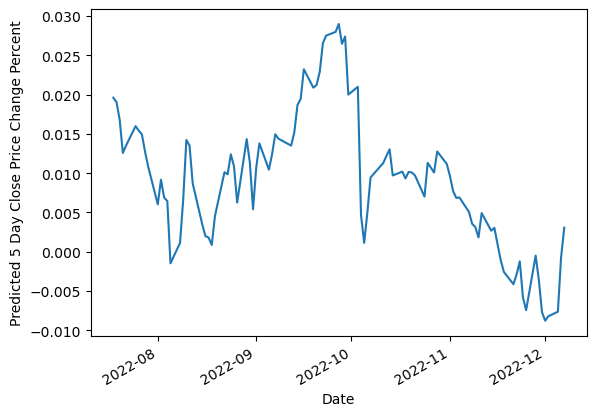

Mean Absolute Error: 0.04016232938094328
Mean Squared Error: 0.0027269017902820797
Root Mean Squared Error: 0.05221974521464156


In [18]:
lr_model = LinearRegression()
scores = cross_val_score(rf_model, X_train, y_train, cv=kf)
print('Training Mean accuracy:', scores.mean())
print('Standard deviation:', scores.std())
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_pred_series.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'Real 5 Day Close Price Change Percent')

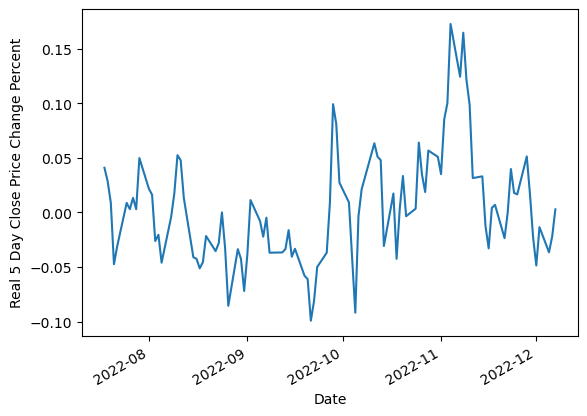

In [19]:
y_test.plot()
plt.ylabel("Real 5 Day Close Price Change Percent")